In [1]:
import numpy as np
from sklearn.metrics import r2_score
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

In [2]:
s_target = 'GOOG'
df = pdr.get_data_yahoo(s_target, start='2014-01-01', end = datetime.now())
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.724083,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.521841,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.828691,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.365179,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.424210,90036218


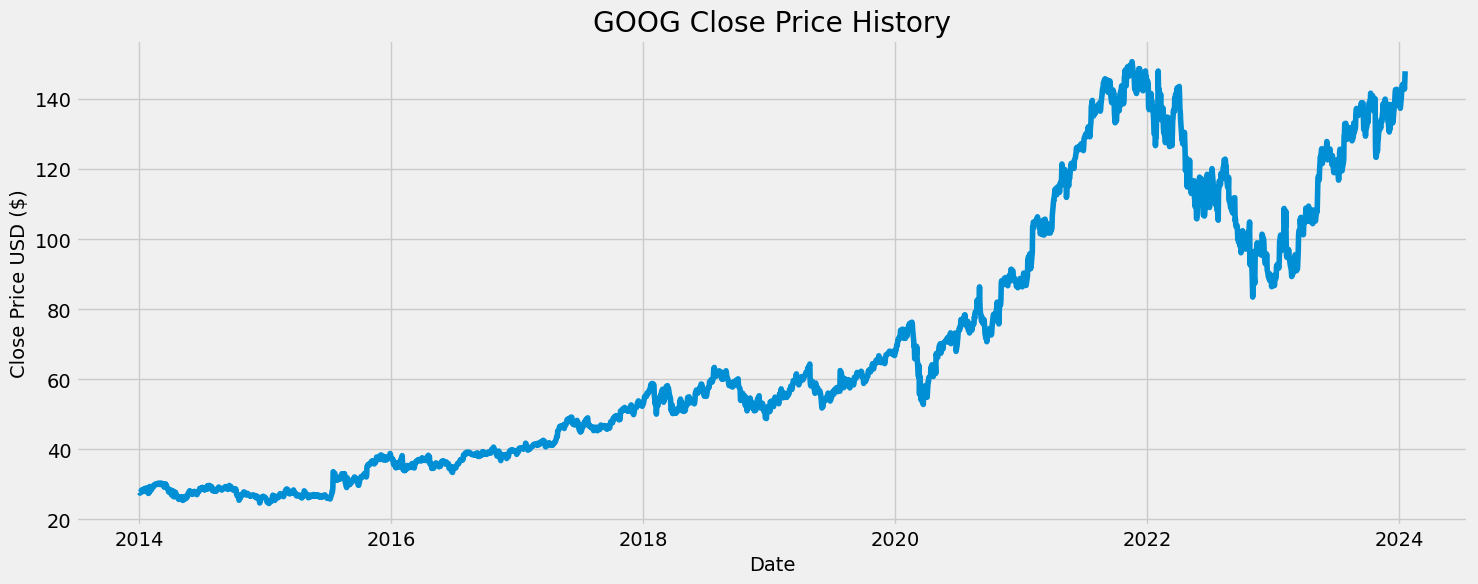

In [3]:
plt.figure(figsize=(16,6))
plt.title(s_target + ' Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.show()

In [4]:
data = df.filter(['Close'])
dataset = data.values
# print(dataset)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02508157],
       [0.02347837],
       [0.02591081],
       ...,
       [0.9380177 ],
       [0.95466474],
       [0.97828758]])

In [7]:
training_data_len = int(np.ceil(len(dataset) * .8))

window_size = 60

train_data = scaled_data[0:training_data_len, :]

x_train, y_train = [], []
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape, y_train.shape)

(1964, 60, 1) (1964,)


In [8]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
62/62 [==============================] - 4s 32ms/step - loss: 0.0079
Epoch 2/100
62/62 [==============================] - 2s 34ms/step - loss: 0.0020
Epoch 3/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0022
Epoch 4/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0020
Epoch 5/100
62/62 [==============================] - 2s 36ms/step - loss: 0.0017
Epoch 6/100
62/62 [==============================] - 2s 36ms/step - loss: 0.0016
Epoch 7/100
62/62 [==============================] - 2s 36ms/step - loss: 0.0021
Epoch 8/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0015
Epoch 9/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0014
Epoch 10/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0016
Epoch 11/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0021
Epoch 12/100
62/62 [==============================] - 2s 35ms/step - loss: 0.0015
Epoch 13/100
62/62 [=====

In [11]:
# テストデータを作成
test_data = scaled_data[training_data_len - window_size: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])

# numpy arrayに変換
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [12]:
# 予測を実行する
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# 二乗平均平方根誤差（RMSE）: 0に近いほど良い
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

# 決定係数(r2) : 1に近いほど良い
r2s = r2_score(y_test, predictions)
print(r2s)

16/16 [==============================] - 1s 9ms/step
7.961381886940319
0.7659619457542108


/var/folders/9p/d75dcmnd25q2q364w0k79k3h0000gn/T/ipykernel_49127/3339233618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


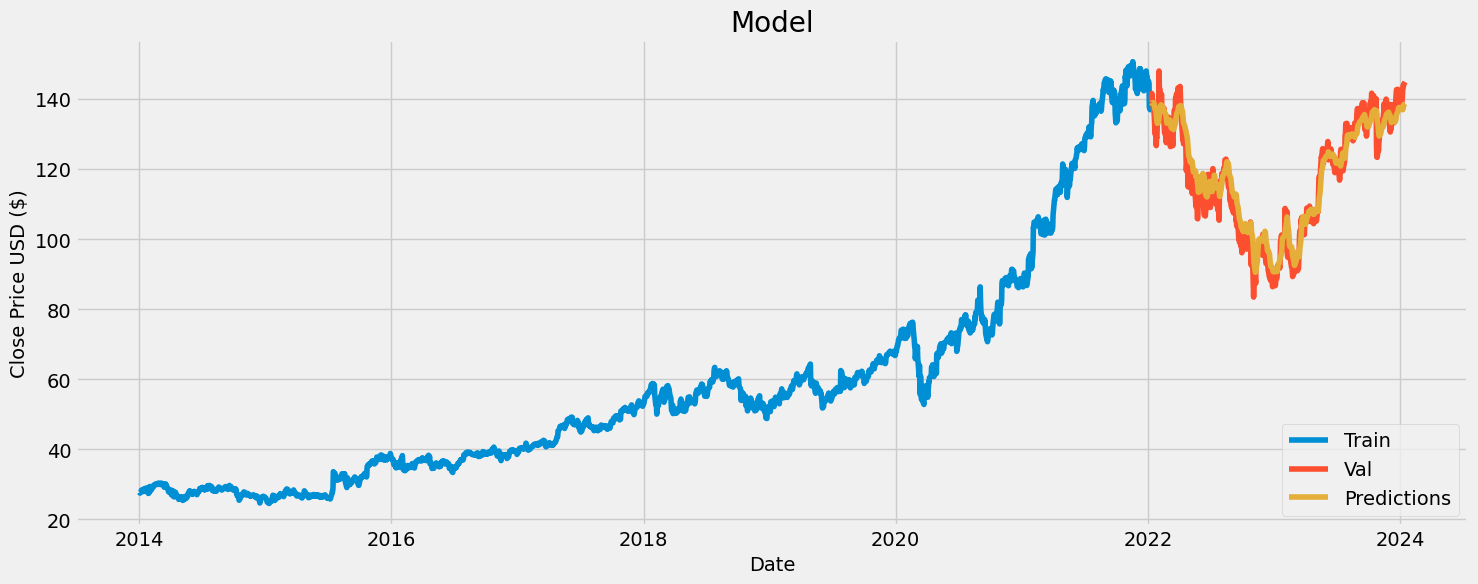

In [23]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               